# Sprint10
## ディープニューラルネットワークスクラッチ

データ取得と前処理

In [103]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [104]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [105]:
X_train=X_train.reshape(-1,784)
X_test=X_test.reshape(-1,784)
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

In [106]:
enc=OneHotEncoder(handle_unknown='ignore',sparse=False)
y_train_one_hot=enc.fit_transform(y_train[:,np.newaxis])
y_test_one_hot=enc.transform(y_test[:,np.newaxis])

In [107]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)

バッチクラス導入

In [108]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練用データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop
    
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]
    

## 【問題1】全結合層のクラス化

In [134]:
class FC:
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        init = initializer
        self.n_nodes1 = n_nodes1
        self.W = init.W(n_nodes1, n_nodes2)
        self.B = init.B(n_nodes2) 

    def forward(self, X):
        self.z = X
        self.a = X@self.W + self.B
        return self.a
    
    def backward(self, dA):
        dZ = dA @ self.W.T
        self.L_W = self.z.T @ dA
        self.L_B = np.sum(dA, axis=0)
        # 更新
        self = self.optimizer.update(self)
        return dZ

## 【問題2】初期化方法のクラス化

In [135]:
class SimpleInitializer:
    def __init__(self, sigma):
        self.sigma = sigma
    def W(self, n_nodes1, n_nodes2):
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        
        return W
    
    def B(self, n_nodes2):
        B  = self.sigma * np.random.randn(n_nodes2)
        return B


## 【問題3】最適化手法のクラス化

In [136]:
class SGD:
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer):
        layer.W = layer.W -  self.lr * layer.L_W
        layer.B = layer.B - self.lr*layer.L_B
        return layer

## 【問題4】活性化関数のクラス化

In [137]:
class Tanh:
    
    def forward(self, X):
        self.A = X
        
        return (np.exp(X) - np.exp(-X)) / (np.exp(X) + np.exp(-X))
    
    def backward(self, Z):
        
        tanh = Tanh()
        a = tanh.forward(self.A)
        a = a**2
        a = 1- a
        L_A = Z * a
    
        
        return L_A

In [138]:
class Softmax:
    def forward(self, A):
        softmax = np.empty((A.shape[0], A.shape[1]))
        exp_a = np.exp(A)
        exp_sum = np.sum(exp_a, axis=1)
        for i in range(A.shape[0]):
            softmax[i] = exp_a[i] / exp_sum[i]
            
        return softmax
    
    def backward(self, Z, Y):
        L_A = Z - Y
        self.cross_entropy = -np.average(np.sum(Y*np.log(Z), axis=1))
        
        return L_A

In [116]:
class Sigmoid:
    def __init__(self):
        pass
    
    def forward(self, X):
        self.A = sigmoid(X)
        return self.A
    
    def backward(self, dZ):
        return dZ * (1 - self.A) * self.A

## 【問題5】ReLUクラスの作成

In [117]:
class Relu:
    def forward(self, X):
        self.A = X
        return np.maximum(0, X)
    
    def backward(self, Z):
        
        return Z * np.maximum(np.sign(self.A), 0)

## 【問題6】重みの初期値

In [118]:
class Xaver_Initilizer:
    
    def __init__(self, n_node1):
        self.sigma =  1 / np.sqrt(n_node1)
        
    def W(self, n_nodes1, n_nodes2):
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    
    def B(self, n_nodes2):
        B  = self.sigma * np.random.randn(n_nodes2)
        return B

In [120]:
class He_Initilizer:
    
    def __init__(self, n_node1):
        self.sigma = np.sqrt(2/n_node1)
        
    def W(self, n_nodes1, n_nodes2):
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    
    def B(self, n_nodes2):
        B  = self.sigma * np.random.randn(n_nodes2)
        return B

## 【問題7】最適化手法

In [139]:
class AdaGrad:
    
    def __init__(self, lr):
        self.lr = lr
        self.H_W = 1
        self.H_B = 1

    def update(self, layer):
        self.H_W = self.H_W + (layer.L_W**2)
        self.H_B = self.H_B + (layer.L_B**2)
        layer.W = layer.W -  self.lr * 1 / np.sqrt(self.H_W) * layer.L_W
        layer.B = layer.B - self.lr * 1 / np.sqrt(self.H_B) * layer.L_B     
        return layer

## 【問題8】クラスの完成

In [140]:
class ScratchDeepNeuralNetrowkClassifier:
    """
    スクラッチで実装したディープニューラルネットワーク
    """
    def __init__(self,epochs, optimizer, lr=0.01, sigma=0.01):
        
        self.epochs = epochs
        self.lr = lr
        self.sigma = sigma
        self.loss = []
        self.optimizer = optimizer
        
    def fit(self, X, Y, node_list, act_list, initializer):
        """
        学習を行うメソッド
        Params
        -----------------
        X:訓練データ　                                           array
        Y:訓練データの正解ラベル(one_hot)     　array
        node_list:入力層から出力層までのノード数を格納したリスト
        act_list:活性化関数を格納したリスト
        initializer:重みの初期値を決定するクラス
        optimizer:最適化手法のクラス
        
        """
        #全結合層を保存するリスト
        self.FC_list = []
        if initializer == SimpleInitializer:
            initializer = SimpleInitializer(self.lr)
            for i in range(len(node_list) - 1):
                self.FC_list.append(FC(node_list[i], node_list[i+1], initializer, self.optimizer(self.lr)))
        else:
            for i in range(len(node_list) - 1):
                self.FC_list.append(FC(node_list[i], node_list[i+1], initializer(node_list[i]), self.optimizer(self.lr)))
            
                
                
        #活性化関数を保存するリスト
        self.activation_list = []
        for i in range(len(act_list)):
            self.activation_list.append(act_list[i])
            
        #エポック回数分学習    
        for i in range(self.epochs):
            get_mini_batch = GetMiniBatch(X  , Y , batch_size=20)
            for X_train_min, t_train_min in get_mini_batch:
                #forward処理
                Z = X_train_min
                for i in range(len(self.activation_list)):
                    A = self.FC_list[i].forward(Z)
                    Z =  self.activation_list[i].forward(A)
                    
                #backward処理
                dA = self.activation_list[-1].backward(Z, t_train_min)
                dZ = self.FC_list[-1].backward(dA)
                for i in range(len(self.activation_list)-1):
                    dA = self.activation_list[-i-2].backward(dZ)
                    dZ = self.FC_list[-i-2].backward(dA)
                    
            #lossを保存する処理    
            Z = X
            for i in range(len(self.activation_list)):
                A = self.FC_list[i].forward(Z)
                Z =  self.activation_list[i].forward(A)
            self.activation_list[-1].backward(Z, Y)
            self.loss.append(self.activation_list[-1].cross_entropy)
            
            
    def predict(self, X):
        Z = X
        for i in range(len(self.activation_list)):
            A = self.FC_list[i].forward(Z)
            Z =  self.activation_list[i].forward(A)
            
        y = np.argmax(Z, axis=1)
        return y

## 【問題9】学習と推定

In [141]:
node_list = [784, 400, 200, 10]
act_list = [Tanh(), Tanh(), Softmax()]
dnn = ScratchDeepNeuralNetrowkClassifier(epochs=3, optimizer = SGD)
dnn.fit(X_train, y_train, node_list, act_list, SimpleInitializer)

In [143]:
y_pred = dnn.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.9601


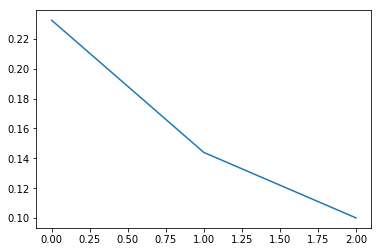

In [144]:
plt.plot(dnn.loss)